### **Part 3: WGAN-GP for Unpaired Image-to-Image Translation** (15 points)  

#### **Task Overview**  
In this part, you will implement a **Wasserstein GAN with Gradient Penalty (WGAN-GP)** to perform unpaired domain transfer between colored MNIST digits. Unlike CycleGAN (discussed in class), your solution must rely solely on:  
- **WGAN-GP losses** (discriminator/critic + gradient penalty),  
- **L1 regularization** $\lambda_1\|{\color{blue}G_\theta}(x)-x\|_1$.  

#### **Key Constraints**  
❌ **Prohibited techniques**:  
- Cycle-consistency loss (used in CycleGAN),  
- Pix2Pix losses (paired training assumptions).  

#### **Resources**  
For additional explanation WGANs except lectures and seminars, refer to tutorial: [*From GAN to WGAN*](https://lilianweng.github.io/posts/2017-08-20-gan/).


In [1]:
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from tqdm import tqdm

In [2]:
DEVICE = torch.device(f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

## 1. Dataset Preparation (2 points)

You should
1. Load the MNIST dataset using `torchvision.datasets`
2. Adapt the seminar's dataset class for our setup
3. Configure:
   - Source domain: Digit `2`
   - Target domain: Digit `3`
4. Generate and visualize a batch of samples from both source and target domains

In [3]:
# Assign random color to  gray-scaled image
def random_color(im: torch.Tensor) -> torch.Tensor:
    hue = 360 * np.random.rand()
    d = im * (hue % 60) / 60
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    H = round(hue / 60) % 6
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

In [4]:
class CMNISTDataset(Dataset):
    def __init__(
            self,
            digit: int = 0,
            train : bool = True,
            spat_dim : tuple[int, int] = (16, 16),
            download : bool = False,
            pix_range : tuple[float, float] = (-1.0, 1.0)
        ) -> None:

        _m, _std = pix_range[0]/float(pix_range[0] - pix_range[1]), 1./float(pix_range[1] - pix_range[0])
        TRANSFORM = transforms.Compose([
            transforms.Resize(spat_dim),
            transforms.ToTensor(),
            random_color,
            transforms.Normalize([_m],[_std])
        ])
        
        mnist_full = MNIST(root='./', train=train, download=download)
        mask = mnist_full.targets == digit
        mnist_full.data = mnist_full.data[mask]
        mnist_full.targets = mnist_full.targets[mask]
        mnist_full.transform = TRANSFORM

        self.mnist = mnist_full
    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx : int) -> torch.Tensor:
        return self.mnist[idx][0]

In [5]:
SOURCE_DIGIT = 2
TARGET_DIGIT = 3

In [6]:
source_train = CMNISTDataset(digit=2)
target_train = CMNISTDataset(digit=3)

print(f"Source train: {len(source_train)} images")
print(f"Target train: {len(target_train)} images")

Source train: 5958 images
Target train: 6131 images


In [7]:
def plot_images(batch: torch.Tensor, title: str | None = None) -> None:
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    if title is not None:
        fig.suptitle(title, fontsize=16)
    fig.tight_layout(pad=0.1)
    plt.show()

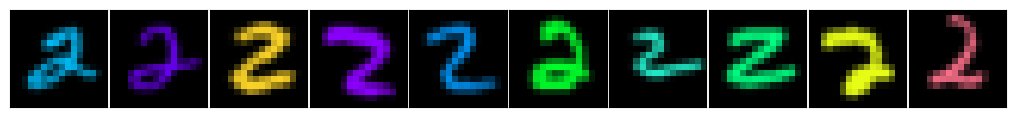

In [8]:
SOURCE_IMAGES = next(iter(DataLoader(source_train, batch_size=10)))
plot_images(SOURCE_IMAGES)

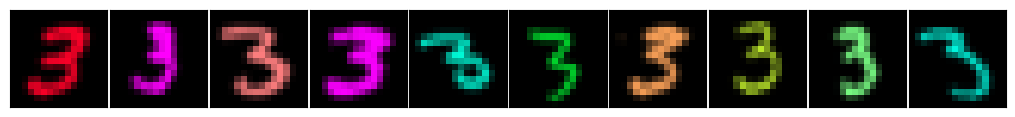

In [9]:
TARGET_IMAGES = next(iter(DataLoader(target_train, batch_size=10)))
plot_images(TARGET_IMAGES)

## 2. Implement the GAN Generator and Discriminator (3 points)

You can use the WGAN architectures from the seminar for image-to-image translation or utilize proposed structure. Your implementation should include:

1. Generator ${\color{blue}G_\theta}(x)$: Takes a `colored MNIST` image $x$ as input
2. Discriminator ${\color{red}D_\omega}(x)$: Standard unconditional discriminator

For architecture reference, you can check these repositories:
- C-WGAN-GP: https://github.com/HayatiYrtgl/C-WGAN-GP/tree/main
- Neural Optimal Transport: https://github.com/iamalexkorotin/NeuralOptimalTransport/tree/main

You may also look up other WGAN-GP implementations online.

In [10]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.res = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
        )


        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)

        # Residual
        res = self.res(e2) + e2  

        # Decoder
        d1 = self.dec1(res)
        d2 = self.dec2(d1)
        return d2


In [11]:
class Critic(nn.Module):
    def __init__(self, in_channels=3):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x).view(-1)

## 3. Implement GAN Model Training (6 points)  

Use **WGAN-GP loss** as the GAN loss. Additionally, train the **WGAN-GP** with $L_1$ regularization, defined as the norm of the difference between the input $x$ and generated ${\color{blue}G_\theta}(x)$ images: $\|{\color{blue}G_\theta}(x)-x\|_1$.  

**Auxiliary utils**. You can use the functions in the cell below to track the GAN training progress. 

In [12]:
def compute_gradient(
    input_tensor: torch.Tensor, output_tensor: torch.Tensor, create_graph: bool = True, retain_graph: bool = True
) -> torch.Tensor:
    """
    Compute gradient of output with respect to input in batch manner.

    Args:
        input_tensor: Input tensor of shape (batch_size, *shape)
        output_tensor: Output tensor of shape (batch_size, 1)
        create_graph: Whether to create computation graph
        retain_graph: Whether to retain computation graph

    Returns:
        Gradient tensor of shape (batch_size, *shape)
    """
    gradients = torch.autograd.grad(
        outputs=output_tensor,
        inputs=input_tensor,
        grad_outputs=torch.ones_like(output_tensor),
        create_graph=create_graph,
        retain_graph=retain_graph,
    )
    return gradients[0]

In [13]:
def generate_gan_metrics(
    generator: nn.Module,
    critic: nn.Module,
    n_samples: int = 5000,
    grid_size: int = 1000,
    compute_grad_norms: bool = True,
):
    """
    Generate evaluation metrics for GAN performance.

    Args:
        generator: Generator model
        critic: Critic/Discriminator model
        n_samples: Number of samples to generate
        grid_size: Size of evaluation grid
        compute_grad_norms: Whether to compute gradient norms

    Returns:
        Tuple containing samples, grid, critic outputs, and optionally gradient norms
    """
    generator.eval()
    critic.eval()

    xs = np.linspace(-3.0, 3.0, grid_size + 1)
    xg, yg = np.meshgrid(xs, xs)
    grid = np.stack((xg.ravel(), yg.ravel()), axis=-1)

    device = next(generator.parameters()).device
    grid_tensor = torch.FloatTensor(grid).to(device)

    with torch.no_grad():
        samples = generator.sample(n_samples).cpu().numpy()
        critic_output = critic(grid_tensor).cpu().numpy()

    if compute_grad_norms:
        grid_tensor.requires_grad_(True)
        critic_output_tensor = critic(grid_tensor)
        gradients = compute_gradient(grid_tensor, critic_output_tensor, create_graph=False, retain_graph=False)
        grad_norms = torch.norm(gradients, dim=-1).cpu().numpy()
        grad_norms = grad_norms.reshape((grid_size + 1, grid_size + 1))

        return samples, grid, critic_output.reshape(-1), grad_norms

    return samples, grid, critic_output.reshape(-1)

In [14]:
def plot_gan_results(
    generated_samples: np.ndarray,
    real_samples: np.ndarray,
    grid: np.ndarray,
    critic_output: np.ndarray,
    critic_grad_norms: np.ndarray,
):
    """
    Visualize GAN training results.

    Args:
        generated_samples: Samples from generator
        real_samples: Ground truth samples
        grid: Evaluation grid
        critic_output: Critic outputs over grid
        critic_grad_norms: Critic gradient norms over grid
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    n_points = int(np.sqrt(len(grid)))

    cnt1 = ax1.contourf(
        grid[:, 0].reshape((n_points, n_points)),
        grid[:, 1].reshape((n_points, n_points)),
        critic_output.reshape((n_points, n_points)),
        levels=25,
        cmap="cividis",
    )
    ax1.scatter(real_samples[:, 0], real_samples[:, 1], marker="x", color="blue", s=0.5, label="Real samples")
    ax1.scatter(
        generated_samples[:, 0], generated_samples[:, 1], marker=".", color="red", s=0.5, label="Generated samples"
    )
    ax1.set_title("Critic Outputs", fontsize=16)
    ax1.legend(fontsize=12)
    fig.colorbar(cnt1, ax=ax1)

    cnt2 = ax2.contourf(
        grid[:, 0].reshape((n_points, n_points)),
        grid[:, 1].reshape((n_points, n_points)),
        critic_grad_norms,
        levels=25,
        cmap="cividis",
    )
    ax2.set_title("Critic Gradient Norms", fontsize=16)
    fig.colorbar(cnt2, ax=ax2)

    plt.tight_layout()
    plt.show()

In [15]:
class GANTrainingMonitor(ABC):
    """Base class for monitoring GAN training progress."""

    def __init__(self, generator: nn.Module, discriminator: nn.Module, reference_data: np.ndarray):
        self.generator = generator
        self.discriminator = discriminator
        self.reference_data = reference_data
        self.generator_losses = []
        self.discriminator_losses = []
        self.device = next(generator.parameters()).device

    def upd_g_loss(self, loss: float):
        self.generator_losses.append(loss)

    def upd_d_loss(self, loss: float):
        self.discriminator_losses.append(loss)

    def plot_losses(self):
        """Plot generator and discriminator loss curves."""
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        for ax, losses, title in zip(
            (ax1, ax2), (self.generator_losses, self.discriminator_losses), ("Generator Loss", "Discriminator Loss")
        ):
            ax.plot(losses)
            ax.set_title(title, fontsize=16)
            ax.set_xlabel("Iteration", fontsize=14)
            ax.set_ylabel("Loss", fontsize=14)
            ax.grid(True)
            ax.tick_params(labelsize=12)

        plt.tight_layout()
        plt.show()

    @abstractmethod
    def visualize(self):
        """Visualize training progress."""
        self.plot_losses()


class GAN2DMonitor(GANTrainingMonitor):
    """Monitor for 2D GAN training."""

    def visualize(self):
        """Visualize 2D GAN results."""
        super().visualize()
        samples, grid, critic_output, grad_norms = generate_gan_metrics(self.generator, self.discriminator)
        plot_gan_results(samples, self.reference_data, grid, critic_output, grad_norms)


class GANImageMonitor(GANTrainingMonitor):
    """Monitor for image-based GAN training."""

    def visualize(self):
        """Visualize image GAN results."""
        clear_output()
        super().visualize()
        plot_images(self.reference_data.cpu(), "Real Samples")
        generated = self.generator(self.reference_data.to(self.device)).detach().cpu()
        plot_images(generated, "Generated Samples")

### 3.1 WGAN-GP Training (4 points)

Implement WGAN-GP training using the seminar's reference code as your starting point and train model.

In [16]:
def wgp_gen_step(
    X: torch.Tensor,  # random batch from the dataset
    G: nn.Module,  # generator model
    D: nn.Module,  # critic model
    G_optim: optim.Optimizer,  # optimizer for generator (Adam/RMSprop/SGD etc.)
) -> torch.Tensor:  # returns the value of loss to track the training statistics
    # G.train()
    # D.eval()
    batch_size = X.size(0)
    X_gen = G(X)
    scores_gen = D(X_gen)
    loss = - scores_gen.mean()
    G_optim.zero_grad()
    loss.backward()
    G_optim.step()
    return loss.item()

In [17]:
def wgp_discr_step(
    X: torch.Tensor,  # Source images (e.g., input to generator)
    Y: torch.Tensor,  # Target images (real data)
    G: nn.Module,  # Generator (image-to-image)
    D: nn.Module,  # Critic (not Discriminator)
    D_optim: optim.Optimizer,
    gp_lambda: float = 10.0,  # Default GP weight (not a Tensor)
) -> float:  # Returns loss for logging
    # G.eval()
    # D.train()
    batch_size = X.size(0)
    with torch.no_grad():
        X_gen = G(X)
    scores_gen = D(X_gen)
    scores_real = D(Y)

    # Gradient Penalty
    t = torch.rand((batch_size,) + (1,) * (X.dim() - 1)).to(X)
    Xt = t * X_gen + (1. - t) * X
    Xt.requires_grad_()
    D(Xt).sum().backward(create_graph=True)
    gradients = Xt.grad
    assert gradients.shape == X.shape
    grad_penalty = (gradients.view(batch_size, -1).norm(dim=1) - 1.).pow(2)
    assert grad_penalty.shape == (batch_size,)
    ####

    loss = scores_gen.mean() - scores_real.mean() + gp_lambda * grad_penalty.mean()
    D_optim.zero_grad()
    loss.backward()
    D_optim.step()
    gradients.detach_() # to avoid memory leak!
    return loss.item()

In [18]:
def train_wgp(
    source_loader: DataLoader,  # dataloader of source dataset
    target_loader: DataLoader,  # dataloader of target dataset
    G: nn.Module,  # generator model
    D: nn.Module,  # critic model
    G_optim: optim.Optimizer,  # optimizer for the generator
    D_optim: optim.Optimizer,  # optimizer for the critic
    critic_steps: int,  # number of discriminators steps per each generator step
    n_epochs: int,  # number of training epochs
    diagnostic: GANTrainingMonitor,  # tracking statistics & visualization
    gp_lambda: torch.Tensor = torch.tensor(10.0),  # gradient penalty coefficient
    visualize_steps: int = 10,  # for visualization purposes
) -> None:
    G.train()
    D.train()
    step_i = 0
    for epoch_i in tqdm(range(n_epochs)):
        for X, Y in zip(source_loader, target_loader):
            X = X.to(DEVICE)  
            Y = Y.to(DEVICE) 

            # DISCRIMINATOR UPDATE
            d_loss = wgp_discr_step(X, Y, G, D, D_optim, gp_lambda)
            diagnostic.upd_d_loss(d_loss)

            # GENERATOR UPDATE
            if step_i % critic_steps == 0:
                g_loss = wgp_gen_step(X, G, D, G_optim)
                diagnostic.upd_g_loss(g_loss)
            step_i += 1

        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            diagnostic.visualize()

In [19]:
BATCH_SIZE = 128
CRITIC_STEPS = 1
LR = 2e-4
N_EPOCHS = 20
GP_LAMBDA = 1

In [20]:
source_cmnist_loader = DataLoader(source_train, batch_size=BATCH_SIZE, shuffle=True)
target_cmnist_loader = DataLoader(target_train, batch_size=BATCH_SIZE, shuffle=True)
G = Generator().to(DEVICE)
D = Critic().to(DEVICE)
G_optim = torch.optim.RMSprop(G.parameters(), lr=LR)
D_optim = torch.optim.RMSprop(D.parameters(), lr=LR)
REFERENCE_IMAGES = next(iter(DataLoader(source_train, batch_size=10)))
diagnostic = GANImageMonitor(G, D, REFERENCE_IMAGES)

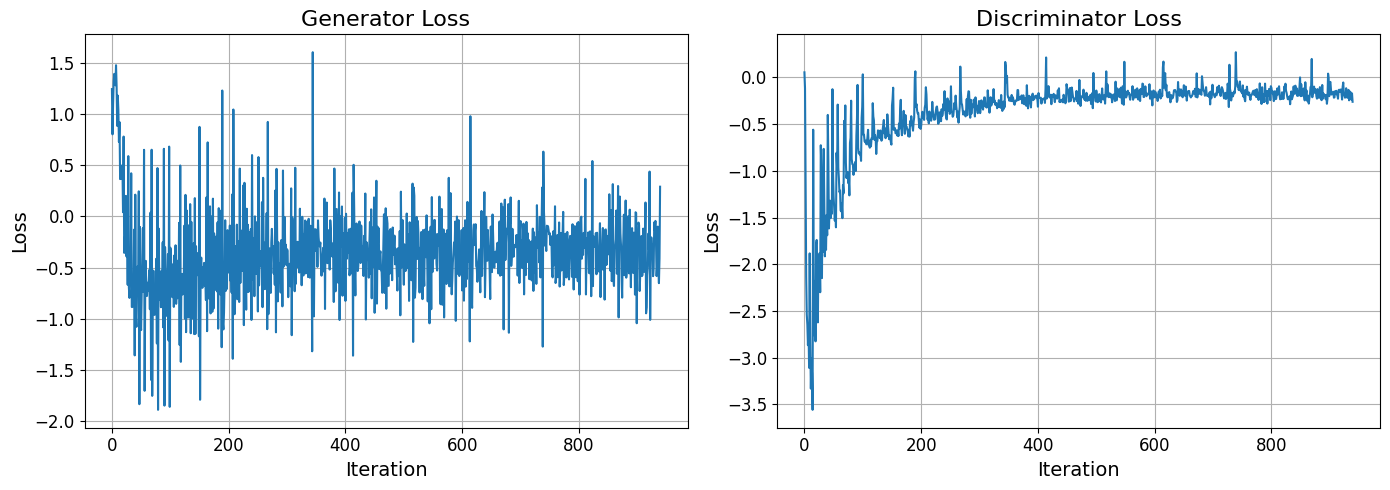

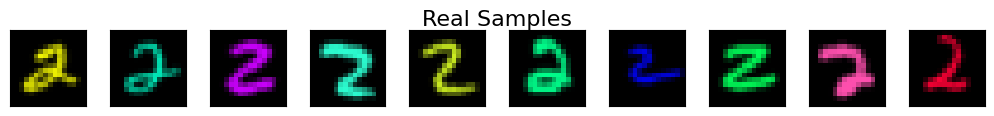

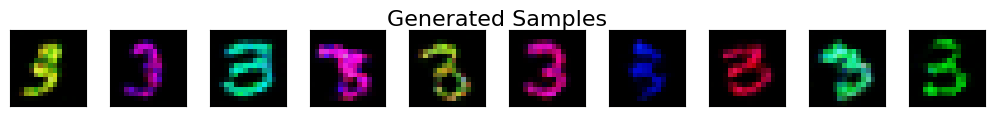

100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


In [21]:
train_losses = train_wgp(
    source_cmnist_loader,
    target_cmnist_loader,
    G,
    D,
    G_optim,
    D_optim,
    critic_steps=CRITIC_STEPS,
    n_epochs=N_EPOCHS,
    diagnostic=diagnostic,
    gp_lambda=torch.tensor(GP_LAMBDA).to(DEVICE),
    visualize_steps=1
)

### 3.2 WGAN-GP with $L_1$ Regularization (2 points)  

Implement and train a **WGAN-GP** model with **$L_1$ regularization**. Modify the WGAN-GP loss to include an $L_1$ penalty term:  
   - Total Loss = WGAN-GP Loss + $\lambda_1 \cdot \|{\color{blue}G_\theta}(x) - x \|_1$  
   - Where $\lambda_1$ controls the regularization strength  
 

In [22]:
def wgp_gen_step_with_l1_reg(
    X: torch.Tensor,  # Input batch (e.g., source images for translation)
    G: nn.Module,  # Generator
    D: nn.Module,  # Critic (WGAN-GP uses a critic, not a discriminator)
    G_optim: torch.optim.Optimizer,
    l1_lambda: float = 10,  # Weight for L1 loss (adjust based on your task)
) -> float:  # Returns loss value for logging
    # G.train()
    # D.eval()
    batch_size = X.size(0)
    X_gen = G(X)
    scores_gen = D(X_gen)
    wgan_loss = - scores_gen.mean()
    l1_loss = torch.abs(X_gen - X).mean()
    loss = wgan_loss + l1_lambda * l1_loss
    G_optim.zero_grad()
    loss.backward()
    G_optim.step()
    return loss.item()

In [23]:
def train_wgp_with_l1_reg(
    source_loader: DataLoader,  # dataloader of source dataset
    target_loader: DataLoader,  # dataloader of target dataset
    G: nn.Module,  # generator model
    D: nn.Module,  # critic model
    G_optim: torch.optim.Optimizer,  # optimizer for the generator
    D_optim: torch.optim.Optimizer,  # optimizer for the critic
    critic_steps: int,  # number of discriminators steps per each generator step
    n_epochs: int,  # number of training epochs
    diagnostic: GANTrainingMonitor,  # tracking statistics & visualization
    gp_lambda: torch.Tensor = torch.tensor(10.0),  # gradient penalty coefficient
    visualize_steps: int = 10,  # for visualization purposes
) -> None: 
    G.train()
    D.train()
    step_i = 0
    for epoch_i in tqdm(range(n_epochs)):
        for X, Y in zip(source_loader, target_loader):
            X = X.to(DEVICE)  
            Y = Y.to(DEVICE) 

            # DISCRIMINATOR UPDATE
            d_loss = wgp_discr_step(X, Y, G, D, D_optim, gp_lambda)
            diagnostic.upd_d_loss(d_loss)

            # GENERATOR UPDATE
            if step_i % critic_steps == 0:
                g_loss = wgp_gen_step_with_l1_reg(X, G, D, G_optim)
                diagnostic.upd_g_loss(g_loss)
            step_i += 1

        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            diagnostic.visualize()

In [24]:
BATCH_SIZE = 128
CRITIC_STEPS = 1
LR = 2e-4
N_EPOCHS = 20
GP_LAMBDA = 1

In [25]:
source_cmnist_loader = DataLoader(source_train, batch_size=BATCH_SIZE, shuffle=True)
target_cmnist_loader = DataLoader(target_train, batch_size=BATCH_SIZE, shuffle=True)
G_L1 = Generator().to(DEVICE)
D_L1 = Critic().to(DEVICE)
G_L1_optim = torch.optim.RMSprop(G_L1.parameters(), lr=LR)
D_L1_optim = torch.optim.RMSprop(D_L1.parameters(), lr=LR)
REFERENCE_IMAGES = next(iter(DataLoader(source_train, batch_size=10)))
diagnostic = GANImageMonitor(G_L1, D_L1, REFERENCE_IMAGES)

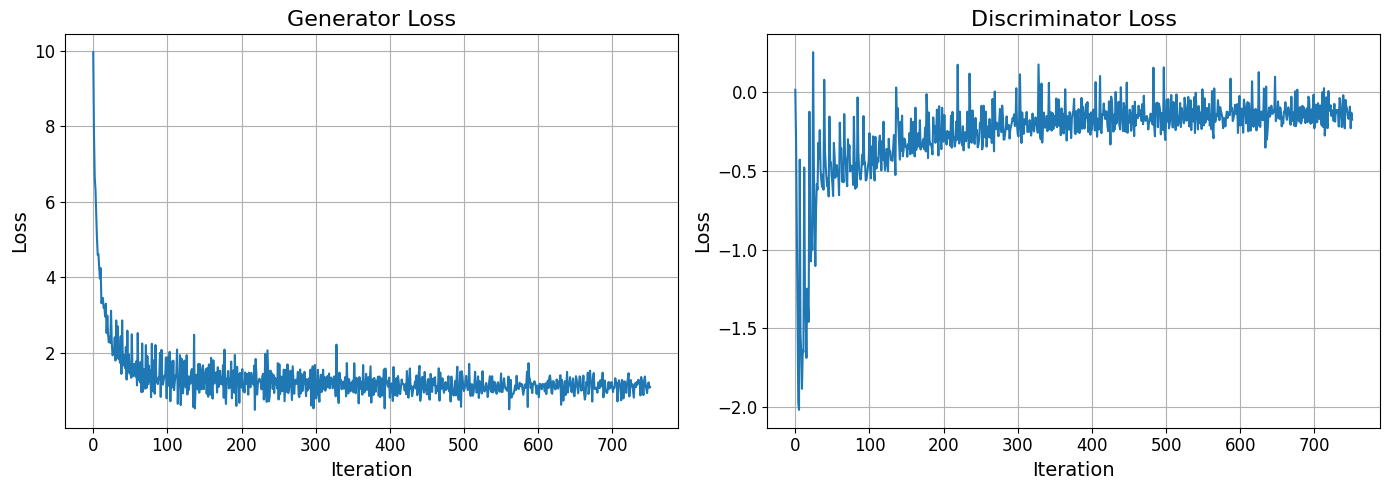

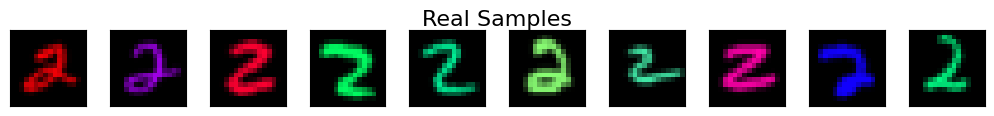

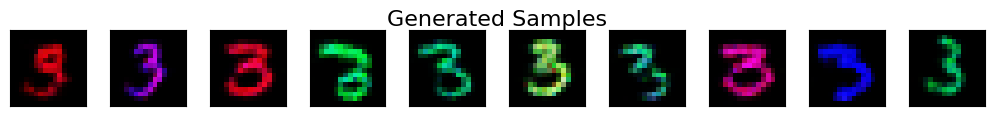

100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


In [26]:
train_losses = train_wgp_with_l1_reg(
    source_cmnist_loader,
    target_cmnist_loader,
    G_L1,
    D_L1,
    G_L1_optim,
    D_L1_optim,
    critic_steps=CRITIC_STEPS,
    n_epochs=N_EPOCHS,
    diagnostic=diagnostic,
    gp_lambda=torch.tensor(GP_LAMBDA).to(DEVICE),
    visualize_steps=5
)

## 4. Model Evaluation (4 points)  

1. **Metric Implementation (3 points)**  
   - Compute the **CMMD (Conditional Maximum Mean Discrepancy)** metric from:  
     [*Rethinking FID: Towards a Better Evaluation Metric for Image Generation*](https://arxiv.org/pdf/2401.09603)  
   - Apply it to assess your model’s performance on the **MNIST test set**.  

2. **Qualitative Visualization (0.5 points)**  
   - Generate and plot domain transfer results (digit **2 $\to$ 3**) for the **ColoredMNIST** dataset.  

3. **Analysis (0.5 points)**  
   - Summarize key observations (e.g., mode collapse, artifacts, or successful transfers).  

### 4.1 Computing CMMD Scores (3 points)

For this part, please use the PyTorch version of CMMD from [this GitHub repo](https://github.com/sayakpaul/cmmd-pytorch/tree/main). It's a direct translation of the original [Google Research JAX implementation](https://github.com/google-research/google-research/tree/master/cmmd), just in PyTorch.

A quick heads-up - we'd really appreciate it if you could stick to this exact implementation. When everyone uses the same codebase, it makes it much easier for the TAs to check your work and give you fair grades. Please try to keep the core CMMD calculation part as-is.

In [27]:
# The bandwidth parameter for the Gaussian RBF kernel. See the paper for more
# details.
_SIGMA = 10
# The following is used to make the metric more human readable. See the paper
# for more details.
_SCALE = 1000

In [28]:
def mmd(x: np.ndarray, y: np.ndarray) -> torch.Tensor:
    """Memory-efficient MMD implementation in JAX.

    This implements the minimum-variance/biased version of the estimator described
    in Eq.(5) of
    https://jmlr.csail.mit.edu/papers/volume13/gretton12a/gretton12a.pdf.
    As described in Lemma 6's proof in that paper, the unbiased estimate and the
    minimum-variance estimate for MMD are almost identical.

    Note that the first invocation of this function will be considerably slow due
    to JAX JIT compilation.

    Args:
      x: The first set of embeddings of shape (n, embedding_dim).
      y: The second set of embeddings of shape (n, embedding_dim).

    Returns:
      The MMD distance between x and y embedding sets.
    """
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)

    x_sqnorms = torch.diag(torch.matmul(x, x.T))
    y_sqnorms = torch.diag(torch.matmul(y, y.T))

    gamma = 1 / (2 * _SIGMA**2)
    k_xx = torch.mean(
        torch.exp(-gamma * (-2 * torch.matmul(x, x.T) + torch.unsqueeze(x_sqnorms, 1) + torch.unsqueeze(x_sqnorms, 0)))
    )
    k_xy = torch.mean(
        torch.exp(-gamma * (-2 * torch.matmul(x, y.T) + torch.unsqueeze(x_sqnorms, 1) + torch.unsqueeze(y_sqnorms, 0)))
    )
    k_yy = torch.mean(
        torch.exp(-gamma * (-2 * torch.matmul(y, y.T) + torch.unsqueeze(y_sqnorms, 1) + torch.unsqueeze(y_sqnorms, 0)))
    )

    return _SCALE * (k_xx + k_yy - 2 * k_xy)

Install necessaty libraries.

In [29]:
#!uv pip install transformers accelerate -q

In [30]:
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection

_CLIP_MODEL_NAME = "openai/clip-vit-large-patch14-336"
_CUDA_AVAILABLE = torch.cuda.is_available()


def _resize_bicubic(images, size):
    images = torch.from_numpy(images.transpose(0, 3, 1, 2))
    images = torch.nn.functional.interpolate(images, size=(size, size), mode="bicubic")
    images = images.permute(0, 2, 3, 1).numpy()
    return images

class ClipEmbeddingModel:
    """CLIP image embedding calculator."""

    def __init__(self):
        self.image_processor = CLIPImageProcessor.from_pretrained(_CLIP_MODEL_NAME)

        self._model = CLIPVisionModelWithProjection.from_pretrained(_CLIP_MODEL_NAME).eval()
        if _CUDA_AVAILABLE:
            self._model = self._model.cuda()

        self.input_image_size = self.image_processor.crop_size["height"]

    @torch.no_grad()
    def embed(self, images):
        """Computes CLIP embeddings for the given images.

        Args:
          images: An image array of shape (batch_size, height, width, 3). Values are
            in range [0, 1].

        Returns:
          Embedding array of shape (batch_size, embedding_width).
        """

        images = _resize_bicubic(images, self.input_image_size)
        inputs = self.image_processor(
            images=images,
            do_normalize=True,
            do_center_crop=False,
            do_resize=False,
            do_rescale=False,
            return_tensors="pt",
        )
        if _CUDA_AVAILABLE:
            inputs = {k: v.to("cuda") for k, v in inputs.items()}

        image_embs = self._model(**inputs).image_embeds.cpu()
        image_embs /= torch.linalg.norm(image_embs, axis=-1, keepdims=True)
        return image_embs

In [31]:
def rescale(tensor, input_range=(-1, 1), output_range=(0, 1)):

    in_min, in_max = input_range
    out_min, out_max = output_range

    tensor = (tensor - in_min) / (in_max - in_min) * (out_max - out_min) + out_min

    tensor = torch.clamp(tensor, out_min, out_max)

    return tensor

In [32]:
def compute_embeddings(
    dataset: Dataset,
    embedding_model: ClipEmbeddingModel,
    batch_size: int = 32,
    max_samples: int = None,
) -> np.ndarray:
    """ 
    Compute embeddings for a dataset in batches.
    
    Args:
        dataset: Input dataset
        embed_fn: Function that takes images and returns embeddings
        batch_size: Number of samples per batch
        max_samples: Maximum number of samples to process
        
    Returns:
        Array of embeddings with shape (num_samples, embedding_dim)
    """
    if max_samples is not None:
        dataset = torch.utils.data.Subset(dataset, range(max_samples))

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_embs = []
    for batch in tqdm(dataloader):
        

        # Normalize to the [0, 1] range.
        image_batch = rescale(batch)
        image_batch = image_batch.numpy()
        image_batch = image_batch.reshape(-1, 16, 16, 3)
        if np.min(image_batch) < 0 or np.max(image_batch) > 1:
            raise ValueError(
                "Image values are expected to be in [0, 1]. Found:" f" [{np.min(image_batch)}, {np.max(image_batch)}]."
            )

        # Compute the embeddings using a pmapped function.
        embs = np.asarray(
            embedding_model.embed(image_batch)
        )  # The output has shape (num_devices, batch_size, embedding_dim).
        all_embs.append(embs)

    all_embs = np.concatenate(all_embs, axis=0)

    return all_embs

In [33]:
source_test = CMNISTDataset(digit=2, train=False)
target_test = CMNISTDataset(digit=3, train=False)

In [34]:
embedding_model = ClipEmbeddingModel()
TEST_BATCH_SIZE = 128

In [35]:
gt_embs = compute_embeddings(target_test, embedding_model, TEST_BATCH_SIZE)

100%|██████████| 8/8 [00:27<00:00,  3.44s/it]


In [36]:
def generate_images(
    dataset: Dataset,
    G: nn.Module,
    batch_size: int,
    device: torch.device = DEVICE,
) -> torch.Tensor:
    """
    Generate images using a trained generator model.

    Args:
        dataset: Input dataset containing source images
        generator: Trained generator model
        batch_size: Number of images to process per batch
        input_range: Range of generator's output
        output_range: Desired output range
        device: Device to run computation on

    Returns:
        Tensor containing all generated images (shape: [N, C, H, W]) from [0, 1]
    """
    generated_images = []

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    G.eval()

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)

            generated_batch = G(batch)

            generated_batch = rescale(generated_batch)

            generated_images.append(generated_batch)

    generated_images = torch.cat(generated_images, dim=0)

    return generated_images.cpu()



In [37]:
wgan_gp_generated_test = generate_images(source_test, G, TEST_BATCH_SIZE)
wgan_gp_emb = compute_embeddings(wgan_gp_generated_test, embedding_model, TEST_BATCH_SIZE, 1024)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:28<00:00,  3.50s/it]


In [38]:
wgan_gp_l1_generated_test = generate_images(source_test, G_L1, TEST_BATCH_SIZE)
wgan_gp_l1_emb = compute_embeddings(wgan_gp_l1_generated_test, embedding_model, TEST_BATCH_SIZE, 1024)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:28<00:00,  3.52s/it]


In [ ]:
test = next(iter(DataLoader(source_test, batch_size=10, shuffle=False)))
plot_images(test,'ColoredMNIST: input samples')

In [39]:
wgan_gp_cmmd = mmd(gt_embs, wgan_gp_emb)
print(f"CMMD for WGAN-GP on ColoredMNIST: {wgan_gp_cmmd}")

CMMD for WGAN-GP on ColoredMNIST: 0.7121562957763672


In [40]:
wgan_gp_l1_cmmd = mmd(gt_embs, wgan_gp_l1_emb)
print(f"CMMD for WGAN-GP with L1 regularization on ColoredMNIST: {wgan_gp_l1_cmmd}")

CMMD for WGAN-GP with L1 regularization on ColoredMNIST: 0.6506443023681641


### 4.2 Qualitative results of GAN model (0.5 points)

Plot obtained images.

In [41]:
SOURCE_TEST = source_test


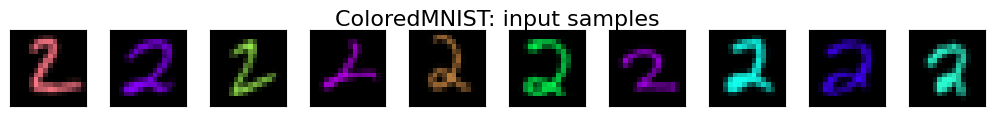

In [47]:
batch = next(iter(DataLoader(SOURCE_TEST, batch_size=10, shuffle=False)))
plot_images(batch,'ColoredMNIST: input samples')

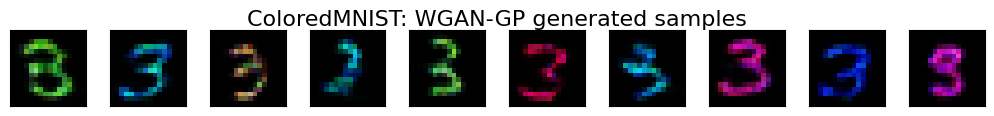

In [50]:
batch_gen = G(batch.to(DEVICE)).detach().cpu()
plot_images(batch_gen,'ColoredMNIST: WGAN-GP generated samples')

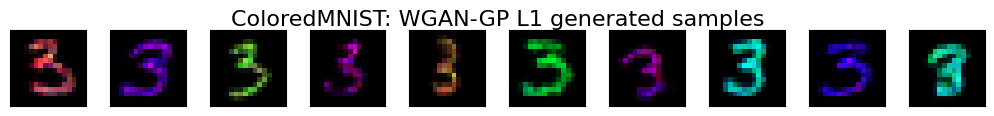

In [51]:
batch_gen_l1 = G_L1(batch.to(DEVICE)).detach().cpu()
plot_images(batch_gen_l1,'ColoredMNIST: WGAN-GP L1 generated samples')

### 4.3 Summary (0.5 points)
| Model Type               | Loss Function       | CMMD Score ($\downarrow$ better) |  
|--------------------------|---------------------|----------------------|  
| WGAN-GP      | WGAN-GP loss | 0.71  | 
| WGAN-GP  | WGAN-GP loss + $L_1$       | 0.65                |  

**Observations:** 

- WGAN-GP with $L_1$ loss performs better (CMMD score: 0.65) than standard WGAN-GP (CMMD score: 0.71).
- $L_1$ loss helps maintain color consistency between input and output samples.
- Visual quality is quite good